<a href="https://colab.research.google.com/github/amelliaaas/PraktikumML_282-305/blob/main/TugasPraktikum4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **1. Load Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
%cd /content/drive/MyDrive/Covid_data/Covid19-dataset/datasets

/content/drive/MyDrive/Covid_data/Covid19-dataset/datasets


In [14]:
!ls

test  train  val


In [ ]:
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 99% 156M/158M [00:01<00:00, 104MB/s] 
100% 158M/158M [00:01<00:00, 106MB/s]


In [ ]:
!ls

covid19-image-dataset.zip  kaggle.json


In [ ]:
!unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
!ls

Covid19-dataset  kaggle.json


In [ ]:
!mkdir dataset

In [15]:
import os
base_dir = 'datasets'

train_dir = os.path.join(base_dir, 'test')
test_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')

test_covid_dir = os.path.join(test_dir, 'Covid')
test_normal_dir = os.path.join(test_dir, 'Normal')
test_pneumonia_dir = os.path.join(test_dir, 'Viral Pneumonia')

val_covid_dir = os.path.join(val_dir, 'Covid')
val_normal_dir = os.path.join(val_dir, 'Normal')
val_pneumonia_dir = os.path.join(val_dir, 'Viral Pneumonia')


In [16]:
ls

test/  train/  val/


In [17]:
test_covid_dir

'datasets/train/Covid'

In [18]:
ls

test/  train/  val/


**2. Spliting Data**

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(train_dir, output="Covid19-dataset/datasets", seed=1337, ratio=(.7, .15, .15))

Copying files: 311 files [00:07, 41.98 files/s]


**4. Prerocessing**

In [25]:
base_dir = "/content/drive/MyDrive/Covid_data/Covid19-dataset/datasets"


In [26]:
# Definisikan path untuk data train test dan validation
# sesuaikan dengan path anda
import os

train_path = os.path.join(base_dir, 'train')
test_path  = os.path.join(base_dir, 'test')
val_path   = os.path.join(base_dir, 'val')

In [27]:
# TULIS KODE ANDA DISINI

from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

batch_size = 32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

train_gen = augmen_gen.flow_from_directory(
    train_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size= batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=batch_size,
    color_mode ='rgb',
)

Found 215 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Found 51 images belonging to 3 classes.


**5. Modelling**

In [31]:
# IMPORT SEMUA PAKET YANG ANDA PERLUKAN UNTUK MENDEFINISIKAN MODEL DISINI

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import time

In [33]:
# DEFINISIKAN MODEL ANDA DISINI

#Feature Selection
model = Sequential()

model.add(InputLayer(input_shape=[224,224,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())

#Fully Connected Layer
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


In [34]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                      

In [44]:
# TULIS CODE CALLBACKS ANDA DISINI

best_model_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0005, verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [81]:
# TULIS CODE UNTUK TRAINING DISINI
from tensorflow.keras.optimizers import SGD

model.compile(optimizer=SGD(lr=0.001, decay=0.001/20), # decay = learning_rate / batch_size 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [82]:



# TULIS CODE UNTUK MENCETAK LAMA TRAINING TIME DISINI

start = time.time()
H = model.fit_generator(train_gen, epochs=100,validation_data=val_gen, validation_steps = 4, callbacks=[callbacks_list])

End = time.time()
print ("training time: ", End-start,"s")  # the time would be round to 3 decimal in seconds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.7674WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 4 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_accuracy improved from -inf to 0.84444, saving model to best_model.h5
7/7 [==============================] - 34s 5s/step - loss: 0.4563 - accuracy: 0.7674 - val_loss: 0.4090 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 27s 4s/step - loss: 0.3695 - accuracy: 0.8465 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 26s 4s/step - loss: 0.3848 - accuracy: 0.8279 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 26s 3s/step - loss: 0.5050 - accuracy: 0.8047 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 26s 3s/step - loss: 0.4033 - accur

In [59]:
model.save('model.h5')

In [83]:
# IMPORT SEMUA PAKET YANG ANDA PERLUKAN UNTUK MENGEVALUASI MODEL DISINI

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files

**6. Evaluation**

In [84]:
# TULIS CODE UNTUK EVALUASI MODEL DISINI

# model.load_weights(best_model_path)

ypred = model.predict(test_gen)
prediction = np.argmax(ypred, axis=1)
print(classification_report(test_gen.classes, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.82      0.93      0.87        15
           2       0.92      0.80      0.86        15

    accuracy                           0.92        51
   macro avg       0.92      0.91      0.91        51
weighted avg       0.93      0.92      0.92        51



Confusion matrix, without normalization
[[21  0  0]
 [ 1 10  4]
 [ 2  1 12]]


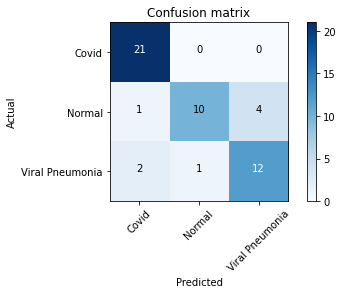

In [49]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

cnf_matrix=confusion_matrix(test_gen.classes,prediction)
plot_confusion_matrix(cnf_matrix, classes=test_gen.class_indices)

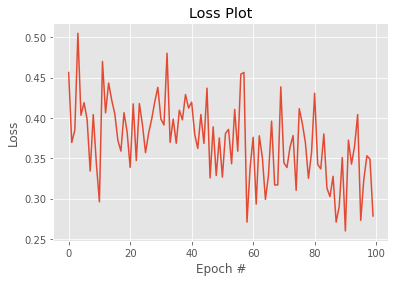

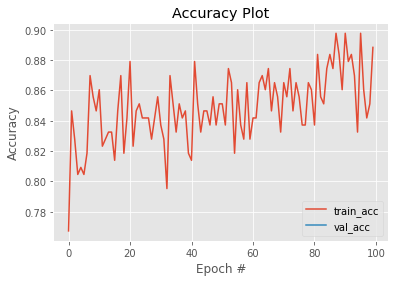

In [87]:
plt.style.use("ggplot")

plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()